# HOMEWORK 2 - TRANSFER FUNCTIONS AND SYSTEM IDENTIFICATION

This homework is about transfer functions and system identification.
There are two problems.

Make a copy of this notebook, and answer the questions.

**Comments**
1.  Nice work, Logan!

# Preliminaries

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import sympy
import tellurium as te
import sympy
import controlSBML as ctl

# Helpers

In [2]:
class PlotResult(object):

    def __init__(self, times=None, yt=None, ax=None):
        self.times = times
        self.yt = yt
        self.ax = ax
        
    def __repr__(self):
        return ""

In [3]:
def plotTF(tf, times=None, is_plot=True, figsize=(5,5)):
    if times is None:
        times = np.linspace(0, 10, 100)
    _, yt = control.forced_response(tf, T=times, U=1)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.plot(times, yt)
        ax.set_xlabel("time")
    else:
        ax = None
    return PlotResult(times=times, yt=yt, ax=ax)

# Tests
tf = control.TransferFunction([1], [1, 0])
plot_result = plotTF(tf, is_plot=False)
assert(isinstance(plot_result, PlotResult))
print("OK!")

OK!


In [4]:
#initializations
#import plotStaircaseResponse used in class

def plotStaircaseResponse(builder, is_plot=True, **kwargs):
    """
    This function circumvents a bug in SISOTransferFunctionBuilder.plotStairCaseResponse.
    It has the same arguments and return value as the original function.
    """
    plot_result = builder.plotStaircaseResponse(is_plot=False, **kwargs)
    # Plot if requested
    if is_plot:
        times = np.array(plot_result.time_series.index)/1000
        df = pd.DataFrame(plot_result.time_series)
        df.index = times
        if "figsize" in kwargs.keys():
            figsize = kwargs["figsize"]
        else:
            figsize = (10, 10)
        legends = list(df.columns)
        fig, ax = plt.subplots(1, figsize=figsize)
        staircase_column = [c for c in df.columns if "staircase" in c][0]
        staircase_values = df[staircase_column].values
        del df[staircase_column]
        ax.plot(df)
        ax2 = ax.twinx()
        # Plot the staircase
        ax2.plot(times, staircase_values, color="red",
              linestyle="--")
        ax2.set_ylabel(staircase_column, color="red")
        ax.legend(df.columns)
    #
    return plot_result

# TESTS
if False:
    plot_response = plotStaircaseResponse(linear_builder, initial_value=2, final_value=10, num_step=5, figsize=(3,3),
                                        legend_crd=(0.5, 1), end_time=100, is_plot=True)
    assert(isinstance(plot_response.time_series, ctl.Timeseries))
    print("OK!")

# Problem 1: Constructing Laplace Transforms for reaction networks

In this problem, you will construct a Laplace transform
for the same branching network we discussed in class, but with
a different input and output.
Below is the reaction network:

\begin{eqnarray}
s_1 & \xrightarrow{k_1 s_1} s_2 \\
s_2 & \xrightarrow{k_2 s_2} s_1 \\
s_1 & \xrightarrow{k_3 s_1} s_3 \\
u & \xrightarrow{k_1 u} s_2 \\
\end{eqnarray}

The input to the system is $u$; the output is $s_2$. (In class, the output
was $s_3$.)

## 1. (5 pts) System equations (**5 pts**)

Write the system equations for this reaction network.

* $\dot{s}_1 = -k_1 s_1 + k_2 s_2 - k_3 s_1$
* $\dot{s}_2 = k_1 s_1 - k_2 s_2 + k_1 u$
* $\dot{s}_3 = k_3 s_1$

## 2. (5 pts) LT of system equations (**5 pts**)

Write the Laplace transforms of the system equations.

* $s S_1 (s) = -k_1 S_1 (s) + k_2 S_2 (s) - k_3 S_1(s)$
* $s S_2 = - k_2 S_2 (s) + k_1 (S_1 (s) + U (s)) $
* $s S_3 (s) = k_3 S_1 (s) $

## 3. (25 pts) Calculate transfer function (**25 pts**)

Calculate the transfer function

$G(s) = \frac{S_2 (s)}{U(s)}$.

We can transform the third system equation so that we have $S_1 (s)$
in terms of $S_3 (s)$. That is,

\begin{eqnarray}
s S_3(s) & = & k_3 S_1 (s) \\
S_1 (s) & = & \frac{S_3(s) s}{k_3}  \\
\end{eqnarray}

We can also express $S_2 (s)$ in terms of $U(s)$ and $S_3(s)$.
\begin{eqnarray}
s S_2 (s) & = & -k_2 S_2 (s) + k_1 S_1 (s) + k_1 U(s) \\
S_2 (s) (s + k_2) & = &  k_1 \frac{s S_3(s)}{k_3}  + k_1 U(s) \\
S_2 (s)  & = &  \frac{1}{s + k_2} \left( k_1 \frac{s S_3(s)}{k_3}  + k_1 U(s) \right) \\
\end{eqnarray}

This allows us to substitute into the second system equation to obtain
the desired result.

\begin{eqnarray}
S_1(s) (s + k_1 + k_3) & = & k_2 S_2(s) \\
\frac{sS_3(s)}{k_3}   (s + k_1 + k_3) & = & k_2 \frac{1}{s + k_2} \left( k_1 \frac{s S_3(s) }{k_3}  + k_1 U(s) \right) \\
\end{eqnarray}

I repeated the process from above, by isolating S2(s). 

In [5]:
s3, s1, s, k1, k2, k3, s2, u = sympy.symbols("s3, s1, s, k1, k2, k3, s2, u")

In [6]:
#expression with other states in terms of output S2, and set to zero

expr = (s*s2/k1 + k2*s2/k1 - u)*(s + k1 + k3) - k2*s2
expr

-k2*s2 + (k1 + k3 + s)*(-u + k2*s2/k1 + s*s2/k1)

In [7]:
#s2 isolated 

s2 = sympy.solve(expr, s2)[0]
s2

k1*u*(k1 + k3 + s)/(k1*s + k2*k3 + k2*s + k3*s + s**2)

In [8]:
print(sympy.latex(s2))

\frac{k_{1} u \left(k_{1} + k_{3} + s\right)}{k_{1} s + k_{2} k_{3} + k_{2} s + k_{3} s + s^{2}}


Transfer function:

$G(s) = \frac{S_2(s)}{U(s)} = \frac{k_{1} \left(k_{1} + k_{3} + s\right)}{k_{1} s + k_{2} k_{3} + k_{2} s + k_{3} s + s^{2}}$

$\frac{S_2 (s)}{U(s)}  =  \frac{k_1 s + k_1 (k_1 + k_3)}
{s^2 + s(k_1 + k_2 + k_3) + k_2 (k_2 +  k_3  - k_1)}$

## 4. (5 pts) Predict step response (** 5 pts **)

Use the ``control`` package to construct the transfer function that you derived in Step 3, and simulate the transfer function. Plot the result.

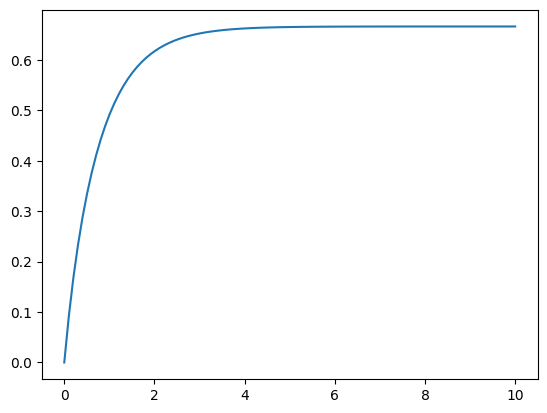

In [9]:
# Initialize constants
k1, k2, k3 = (1, 1, 1)
k1, k2, k3 = (1, 2, 3)
times = np.linspace(0, 10, 100)
# Response to input
tf = control.TransferFunction([k1, k1**2+k1*k3],
                              [1, k1+k2+k3, k2*k3])
_, yt = control.forced_response(tf, T=times, U=1)
# Plot the results
plt.plot(times, yt)

## 5. (5 pts) Simulate in Antimony (**5 pts **)

Write an Antimony model for the original system and simulate it for a step respoinse.

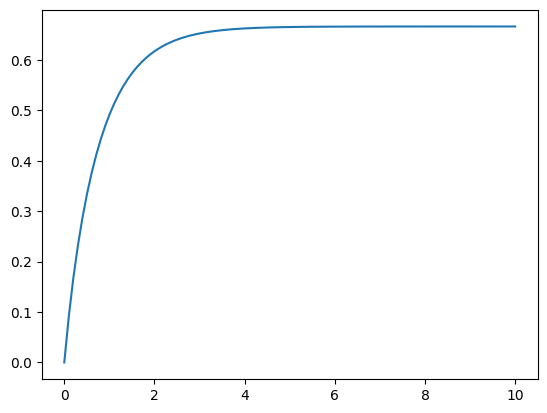

In [28]:
model = """
s1 -> s2; k1*s1
s2 -> s1; k2*s2
s1 -> s3; k3*s1
$u -> s2; k1*u

k1 = 1
k2 = 1
k3 = 1
s1 = 0
s2 = 0
s3 = 0
k2 =2
k3 = 3
$u = 1
"""
rr = te.loada(model)
data = rr.simulate(0, 10, 100)
plt.plot(data["time"], data["[s2]"])

## 6. (5 pts) Analysis (**5 pts **)

1. How does the transfer function you derived and simulated in step 3 compare with the simulation results for the Antimony model in step 4?
1. How does DC gain change as $k_1$ increases?
1. Explain why the DC gain of this system is finite whereas the DC gain of the system with $s_3$ as output does not have finite DC gain.


1) The transfer function from step 3 yielded a very similar logarithmic curved when compared to the Antimony simulation.

2) Let's take a look at how DC gain changes as k1 increases. As we increase the magnitude of k1, the magnitude of DC gain increases ~proportionally. This is because k1 is the coefficient of the highest order of s.

[0.0, 0.11000000000000001, 2.0, 30.0, 110.0, 420.0, 2550.0]
[nan, 1.1, 2.0, 6.0, 11.0, 21.0, 51.0]


/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/ipykernel_95398/1393136738.py:22: RuntimeWarning:

invalid value encountered in double_scalars



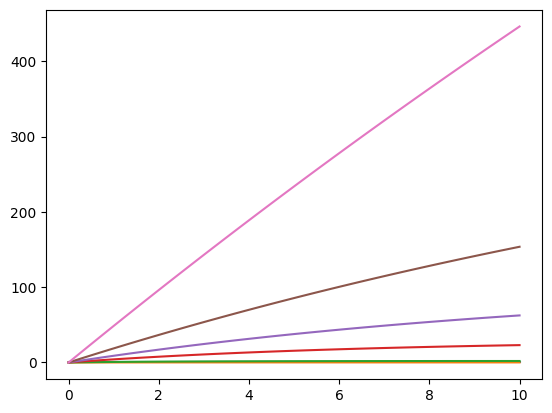

In [11]:
# Initialize constants

k1_list = [0,0.1,1,5,10,20,50]
k2 = 1
k3 = 1


DC_gain = []
for i in k1_list:
    times = np.linspace(0, 10, 100)
    # Response to input
    tf = control.TransferFunction([i, i**2+i*k3],
                              [1, i+k2+k3, k2*k3])
    _, yt = control.forced_response(tf, T=times, U=1)
    # Plot the results
    plt.plot(times, yt)

    DC_gain.append(tf.dcgain())
    
print(DC_gain)

proportion = [DC_gain[i] / k1_list[i] for i in range(len(DC_gain))]

print(proportion)  # Output: [5.0, 5.0, 5.0, 5.0, 5.0]


3. In the system from lecture, the entire denominator of the transfer function is multiplied by s. So, when s goes to zero, the function becomes undefined at any value of k1. For this transfer function, there are k terms that remain in both the numerator and denominator when s goes to zero, resulting in a finite DC gain.

# Problem 2: System Identification

You will do system identification for the system you chose in the first homework.

I am using the inflamation response model from HW1.

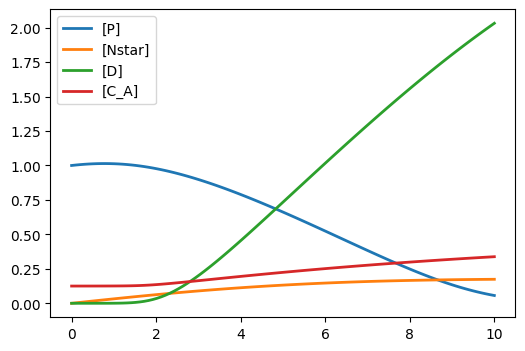

In [12]:
#lets start by plotting the model:

inflam_url = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000714.6?filename=HealthyOutcome.xml"

INFLAM_CTLSB = ctl.ControlSBML(inflam_url, input_names=['Nstar'], output_names=['P'])

INFLAM_CTLSB_RR = INFLAM_CTLSB.roadrunner
INFLAM_CTLSB_RR.simulate(0, 10, 100)
INFLAM_CTLSB_RR.plot()

In [13]:
#first step is to construct the SISOTransferFunctonBuilder
#plug in model to these methods

inflam_builder = INFLAM_CTLSB.makeSISOTransferFunctionBuilder()
inflam_builder.input_name, inflam_builder.output_name

('Nstar', 'P')

## 1. (20 pts) Determine the operating region for you system. (**20 pts**)

Use ``SISOTransferFunctionBuilder`` to plot a staircase of the control input to your system and the measured output.
Explain why you chose the operating region you did (i.e., the value ranges of
the control input).

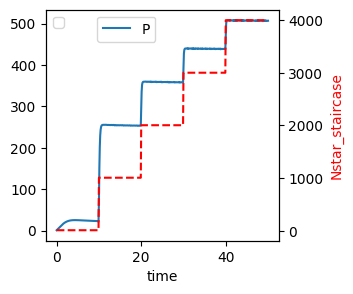

In [14]:
inflam_builder.plotStaircaseResponse(initial_value=10, final_value=4000, figsize=(3,3),
                                    legend_crd=(0.5, 1), end_time=50)

I chose an initial value of 10 and a final value of 4000 because these conditions yielded 1) system stabilization near t =35s, and 2) the most stable step response of parameter "P". Having an initial value <10 yielded a staircase with some sloped instead of what is seen above. Finally, I chose 50 seconds as the end time because this was the smallest increment of time that can show the system stabilizing (thus optimizing run time).

## 2. (20 pts) Find a tranfser function for your system for the operating region. (**20 pts**)

Use ``SISOTransferFunctionBuilder`` to fit a transfer function for your system.
Justify that the transfer function fits sufficiently well and does not overfit.

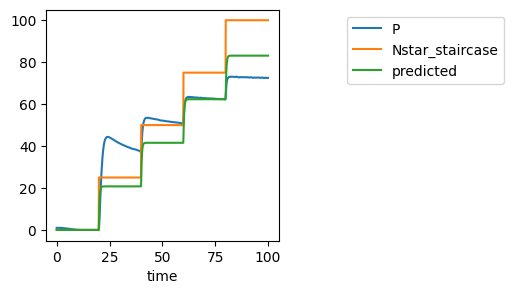

In [15]:
#let's start with a simple transfer function

numer_degree = 0
denom_degree = 1

fitter_result =  inflam_builder.fitTransferFunction(numer_degree+1, denom_degree+1, final_value=100,
                                                   initial_value=0, end_time=100)
ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))

#P is overpredicted from this set of parameters

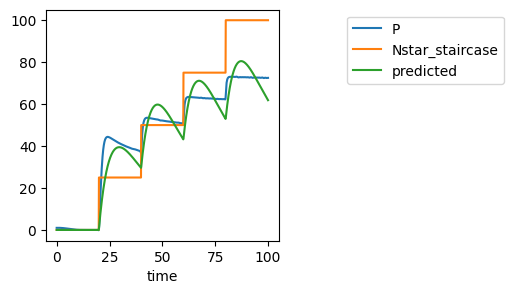

In [16]:
#Staircase was close to predicted, let's see if we can make it closer by increasing degree of polynomial.

numer_degree = 1
denom_degree = 2

fitter_result =  inflam_builder.fitTransferFunction(numer_degree+1, denom_degree+1, final_value=100,initial_value=0, end_time=100)

ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))

#predicted result here starts to become a bit complex. Seems there is some overfitting.

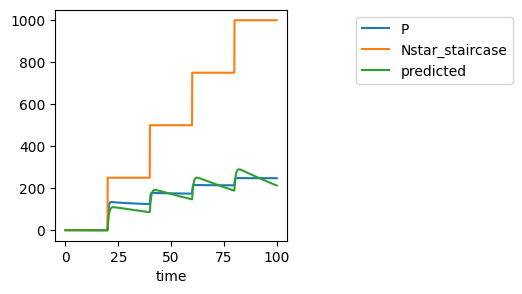

In [17]:
#let's increase the final value 

numer_degree = 1
denom_degree = 2

fitter_result =  inflam_builder.fitTransferFunction(numer_degree+1, denom_degree+1, final_value=1000,initial_value=0, end_time=100)

ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))

#at first glance, it seems that the prediction is getting closer to the actual value, but it is likely due to 
#the extended y-axis

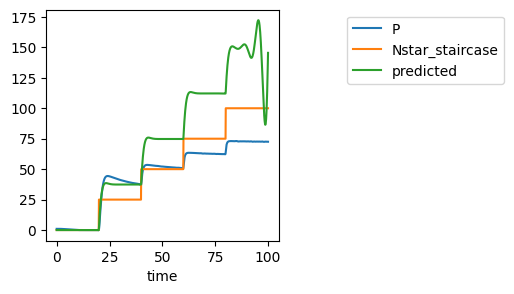

In [18]:
#increasing the polynomial's degree significantly makes the system too complex, prediction becomes unstable
numer_degree = 3
denom_degree = 4

fitter_result =  inflam_builder.fitTransferFunction(numer_degree+1, denom_degree+1, final_value=100,initial_value=0, end_time=100)

ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))


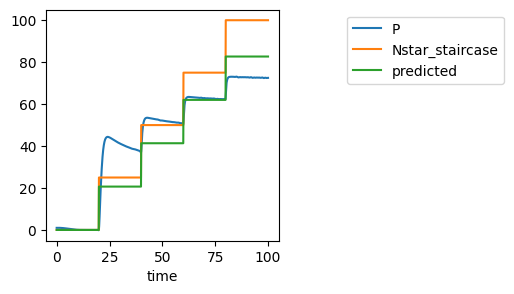

In [19]:
#it looks like reducing the polynomial to zero is actually pretty accurate
#however, the predicted value hovers around P but doesn't seem to be consistently getting closer over time
#this is probably underfit.

numer_degree = 0
denom_degree = 0

fitter_result =  inflam_builder.fitTransferFunction(numer_degree+1, denom_degree+1, final_value=100,initial_value=0, end_time=100)

ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))

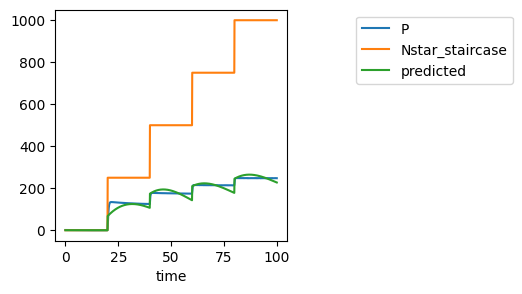

In [20]:
#let's have a 2nd degree polynomial for both the numerator and denominator

numer_degree = 2
denom_degree = 2

fitter_result =  inflam_builder.fitTransferFunction(numer_degree+1, denom_degree+1, final_value=1000,initial_value=0, end_time=100)

ctl.plotOneTS(fitter_result.time_series, figsize=(3,3), legend_crd=(2,1))

#predictions become a bit unstable when numerator degree is increased

I think the solution here is to use a first-degree numerator polynomial and a second-degree denominator polynomial in order to get the best fit. We can try and mess with the operating regions to optimize this.

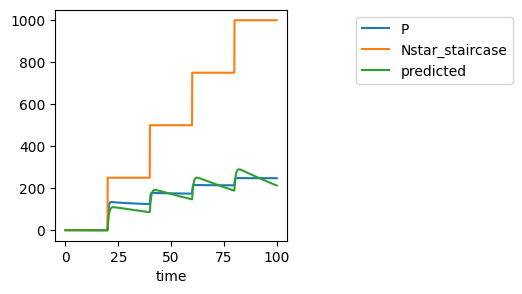

In [21]:
numer_degree = 1
denom_degree = 2

fitter_result_final =  inflam_builder.fitTransferFunction(numer_degree+1, denom_degree+1, final_value=1000,initial_value=0, end_time=100)

ctl.plotOneTS(fitter_result_final.time_series, figsize=(3,3), legend_crd=(2,1))

Changing the operating region makes the prediction look a bit more accurate, but again this is probably an artifact of the axis scaling.

## 3. (10 pts)  Analyze the transfer function.

What is the DC gain? What are the poles? What are the implications for control?

In [22]:
#transfer functionWhat is the DC gain? What are the poles? What are the implications for control?

fitter_result_final.transfer_function

TransferFunction(array([ 4.53713194, -0.02010941]), array([5.80898175, 9.99991863, 0.09636422]))

In [23]:
#std error

fitter_result_final.stderr

{'n0': 778.8787395537973,
 'n1': 3.459850385240841,
 'd0': 997.0255494455135,
 'd1': 1642.5345366380163,
 'd2': 16.52100382856822}

In [24]:
#number of simulations to find best transfer function

fitter_result.nfev

222

In [25]:
#DC gain

fitter_result_final.transfer_function.dcgain()

-0.20868129944514976

A DC gain of -0.21 suggests a few things:

1) The steady-state value of the unit step response is about 0.2 (without a controller). This means that the input signal is only about 20% of the output signal,  so the magnitude of the signal is signficantly increased by the system.

2) A negative DC gain suggests that the polarity of the signal is flip as it is manipulated by the system.

In [26]:
#poles

fitter_result_final.transfer_function.poles()

array([-1.71176703+0.j, -0.00969106+0.j])

The poles of this transfer function are particularly interesting – I tried returning poles for functions with numerator and denominator = 0/0, 1/1, 1/2, and 2/3, and all four sets of poles had one negative number large in magnitude and one negative number small in magnitude. The dominant pole was very close to zero each time, suggesting this system may be inherently prone to a longer settling time despite control.